In [97]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import AutoModel, AutoTokenizer

from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss, BCELoss

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report

from tqdm.notebook import tqdm

from typing import Tuple, List, Dict

DEVICE = "cuda"

In [9]:
!nvidia-smi

Sat Nov 25 10:11:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:23:00.0 Off |                    0 |
|  0%   47C    P0   161W / 300W |   4824MiB / 46068MiB |     41%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [123]:
entailments = np.load("data/meta_data/entailments_scores.npy")

def filter_train_with_nli(train: pd.DataFrame, entailments: np.array, threshold: float) -> pd.DataFrame:
    return train[entailments > threshold]

In [124]:
def get_data_from_paths(paths: List[str]) -> pd.DataFrame:
    dfs = [pd.read_csv(path) for path in paths]

    non_embeddings_columns = ["Исполнитель", "Группа тем", "Текст инцидента", "Тема"]

    embeddings = []
    for df in dfs:
        embeddings.append(df[[column for column in df.columns if column not in non_embeddings_columns]].values)

    embeddings = np.concatenate(embeddings, axis=1)

    df = pd.DataFrame(data=dfs[0][non_embeddings_columns], columns=non_embeddings_columns)

    return pd.concat([df, pd.DataFrame(embeddings)], axis=1)

In [150]:
train1 = get_data_from_paths(paths=[
    "data/final_full_train_tfidf_umap.csv",
])

train1["Группа тем"] = "Группа: " + train1["Группа тем"]

train2 = get_data_from_paths(paths=[
    "data/train_with_embeddings.csv",
])

train2["Группа тем"] = "Группа: " + train2["Группа тем"]

test2 = get_data_from_paths(paths=[
    "data/test_with_embeddings.csv"
])

test2["Группа тем"] = "Группа: " + test2["Группа тем"]

train2 = pd.concat([train2, test2])

train2.index = range(len(train2))
train1.index = range(len(train1))

In [163]:
1528 - 4 - 1024

500

In [165]:
train = pd.concat([train2, train1[[k for k in range(500)]]], axis=1)
train.columns = ["Исполнитель", "Группа тем", "Текст инцидента", "Тема"] + [k for k in range(1524)]

In [172]:
def generate_unique_labels(data: pd.DataFrame) -> List[str]:
    unique_groups = data["Группа тем"].unique().tolist()
    
    unique_themes = []
    for group in unique_groups:
        unique_themes.extend(data[data["Группа тем"] == group]["Тема"].unique().tolist())
    
    return unique_groups + unique_themes

def generate_pytorch_labels(data: pd.DataFrame, uniques: List[str]) -> torch.Tensor:    
    n_uniques = len(uniques)
    
    pytorch_labels = []
    for _, row in data.iterrows():
        labels = torch.zeros(n_uniques)
                
        labels[uniques.index(row["Группа тем"])] = 1
        labels[uniques.index(row["Тема"])] = 1
        
        pytorch_labels.append(labels.reshape(1, -1))
    
    return torch.cat(pytorch_labels)


def generate_tree_of_labels(data: pd.DataFrame, mapping: Dict[str, int]) -> Dict[str, List[str]]:
    tree = {}
    
    for group in data["Группа тем"].unique():
        tree[mapping[group]] = []
        
        for theme in data[data["Группа тем"] == group]["Тема"].unique():
            tree[mapping[group]].append(mapping[theme])
            
    return tree

In [173]:
uniques = generate_unique_labels(train)

mapping = {label: k for k, label in enumerate(uniques)}
reversed_mapping = {k: label for k, label in enumerate(uniques)}

tree = generate_tree_of_labels(train, mapping)

In [174]:
train_labels = generate_pytorch_labels(train, uniques).to(DEVICE).float()

In [175]:
train_embeddings = train[[k for k in range(train.columns[-1] + 1)]]
train_embeddings = torch.from_numpy(train_embeddings.values).to(DEVICE).float()

# test_embeddings = test[[k for k in range(train.columns[-1] + 1)]]
# test_embeddings = torch.from_numpy(test_embeddings.values).to(DEVICE).float()

In [177]:
class Layer(nn.Module):
    
    def __init__(self, dim: int, device: str = "cuda"):
        super().__init__()
                        
        self.linear = nn.Sequential(
            nn.Linear(dim, dim, device=device),
            nn.BatchNorm1d(dim, device=device),
            nn.ReLU(),
        )
        
    def forward(self, x):        
        return self.linear(x)
    
    
class HierarchicalSoftmax(nn.Module):
    
    def __init__(self, tree: Dict[int, List[int]]):
        super().__init__()
        
        self.tree = tree
        self.specified_indexes_list = [list(tree.keys())]
        
        for head in tree.keys():
            self.specified_indexes_list.append(tree[head])
    
    def forward(self, x):
        x = x.clone()
        
        for specified_indexes in self.specified_indexes_list:
            sub_tensor = x[:, specified_indexes]
        
            softmax_result = F.softmax(sub_tensor, dim=1)
        
            x[:, specified_indexes] = softmax_result
            
        return x


class Model(nn.Module):
    
    def __init__(self, embed_dim: int, hidden_dim: int, num_classes: int, n_layers: int = 1, device: str = "cuda"):
        super().__init__()
        
        self.input = nn.Linear(embed_dim, hidden_dim, device=device)
        self.relu = nn.ReLU()
        self.layers = nn.ModuleList([Layer(hidden_dim, device) for _ in range(n_layers)])
        self.output = nn.Linear(hidden_dim, num_classes, device=device)
        
    def forward(self, x):
        x = self.input(x)
        x = self.relu(x)
        
        for layer in self.layers:
            x = layer(x)
        
        return self.output(x)

In [178]:
torch.manual_seed(100)

model = Model(embed_dim=train_embeddings.shape[1], num_classes=train_labels.shape[1], n_layers=1, hidden_dim=1024)

In [179]:
optimizer = Adam(params=model.parameters(), lr=1e-3)
loss_func = BCEWithLogitsLoss()

In [180]:
N_EPOCHS = 400

losses = []

for _ in tqdm(range(N_EPOCHS)):
    outputs = model(train_embeddings)
    
    loss = loss_func(outputs, train_labels)
    loss.backward()
    
    losses.append(loss.item())
    
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/400 [00:00<?, ?it/s]

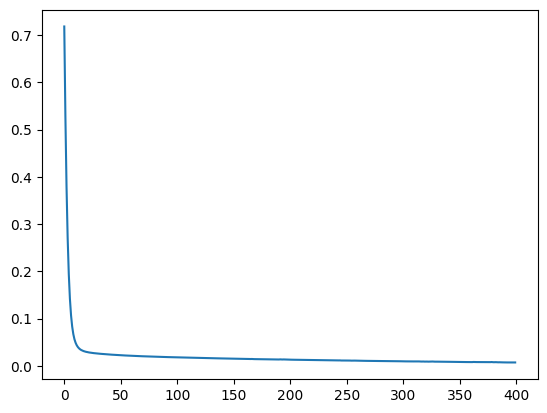

In [181]:
plt.plot(losses)

In [182]:
def predict(output: torch.Tensor, tree: Dict[int, List[int]]):
    softmax = HierarchicalSoftmax(tree)
    
    output = softmax(output)
    
    tree_heads = list(tree.keys())
    
    groups_prob = output[:, tree_heads]
    
    groups_index = groups_prob.argmax(dim=1).tolist()
    
    indexes = []
    for k, gi in enumerate(tqdm(groups_index)):
        theme_index = output[:, tree[gi]].argmax(dim=1)[k].item()
        
        indexes.append([gi, tree[gi][theme_index]])
        
    return indexes

def decode_predictions(predictions):
    decoded_predictions = []

    for pred in predictions:
        decoded_predictions.append([reversed_mapping[pred[0]], reversed_mapping[pred[1]]])
        
    return np.array(decoded_predictions)


def evaluate(true, pred, output_dict=True):
    true_groups, true_themes = true[:, 0], true[:, 1]
    pred_groups, pred_themes = pred[:, 0], pred[:, 1]
    
    return {
        "group": classification_report(true_groups, pred_groups, output_dict=output_dict),
        "theme": classification_report(true_themes, pred_themes, output_dict=output_dict)
    }

In [183]:
outputs_train = model(train_embeddings)

predictions_train = predict(outputs_train, tree)
predictions_train = decode_predictions(predictions_train)

# outputs_test = model(test_embeddings)

# predictions_test = predict(outputs_test, tree)
# predictions_test = decode_predictions(predictions_test)

  0%|          | 0/24287 [00:00<?, ?it/s]

In [184]:
train_true = train[["Группа тем", "Тема"]].values
#test_true = test[["Группа тем", "Тема"]].values

In [185]:
train_report = evaluate(train_true, predictions_train)
#test_report = evaluate(test_true, predictions_test)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [186]:
train_report["group"]["weighted avg"]

{'precision': 0.9661065375097418,
 'recall': 0.9651665500061761,
 'f1-score': 0.9646109453423609,
 'support': 24287.0}

In [192]:
final_test_roma = pd.read_csv("data/final_full_test_tfidf_umap.csv")
final_test_vova = pd.read_csv("")

In [195]:
torch.save(model.state_dict(), "model/final_model_for_deploying_roma")

In [196]:
model

Model(
  (input): Linear(in_features=1524, out_features=1024, bias=True)
  (relu): ReLU()
  (layers): ModuleList(
    (0): Layer(
      (linear): Sequential(
        (0): Linear(in_features=1024, out_features=1024, bias=True)
        (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
  (output): Linear(in_features=1024, out_features=221, bias=True)
)